<a href="https://colab.research.google.com/github/greenlodka/HW_Python/blob/master/HW15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ipymarkup
!pip install transformers

In [ ]:
!wget https://russiansuperglue.com/tasks/download/TERRA

--2021-06-26 20:38:18--  https://russiansuperglue.com/tasks/download/TERRA
Resolving russiansuperglue.com (russiansuperglue.com)... 37.18.107.48
Connecting to russiansuperglue.com (russiansuperglue.com)|37.18.107.48|:443... connected.
HTTP request sent, awaiting response... 500 Internal Server Error
2021-06-26 20:38:18 ERROR 500: Internal Server Error.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
!head drive/MyDrive/TERRa/train.jsonl

{"premise": "Женщину доставили в больницу, за ее жизнь сейчас борются врачи.", "hypothesis": "Женщину спасают врачи.", "label": "entailment", "idx": 0}
{"premise": "Он проводит невидимую грань между настоящим и будущим. В эти минуты все мы подводим главные итоги года, вспоминаем самые важные события. В эти мгновения мы с волнением ждем добрых перемен.", "hypothesis": "В эти минуты все мы подводим друг друга.", "label": "not_entailment", "idx": 1}
{"premise": "Мужчина рассказал: детская коляска, принадлежащая его семье, пропала прямо из подъезда. Как выяснили полицейские, коляску украл сосед мужчины. Он был пьян, и ему нужны были деньги.", "hypothesis": "Сосед часто крадет детские коляски ради денег.", "label": "not_entailment", "idx": 2}
{"premise": "Я просто об этом даже не думаю, потому что если кто-то что-то захочет, никуда не спрячешься.", "hypothesis": "Спрятаться не удастся.", "label": "entailment", "idx": 3}
{"premise": "В ходе проверки нашли дома с наледью и сосульками на крыша

In [42]:
class AbstractStep:
  def __init__(self):
      self.name = "StepName"
      self.extr = "StepExtract"

  def parent(cls):
      return "StepExtract"


In [43]:
import json
import os

class DataReader(AbstractStep):

  file_mapping = {
      "TRAIN": "train.jsonl",
      "TEST": "test.jsonl",
      "VALID": "val.jsonl"
  }

  def __init__(self, dir_path):
      self.train_samples = self.read_file(dir_path, "TRAIN")
      self.test_samples = self.read_file(dir_path, "TEST")
      self.valid_samples = self.read_file(dir_path, "VALID")

  def read_file(self, dir_path, file_name):
      file_path = os.path.join(dir_path, self.file_mapping[file_name])
      jsonl_content = open(file_path).read()
      samples = [json.loads(jline) for jline in jsonl_content.splitlines()]
      print(f"Number of samples - {len(samples)} - in {file_name} dataset ")
      return samples

In [58]:
dr = DataReader("drive/MyDrive/TERRa")

Number of samples - 2616 - in TRAIN dataset 
Number of samples - 3198 - in TEST dataset 
Number of samples - 307 - in VALID dataset 


In [71]:
import pandas as pd


class DataProcessor(AbstractStep):

  sentence_keys = ["premise", "hypothesis"]
  target_label_key = "label"
  
  sentence_separator = "\n"
  dataframe_keys = ["text", "labels"]

  def __init__(self, samples):
    self.text_data, self.target_labels = self.prepare_data(samples)

  def prepare_data(self, samples):
    sentences_pairs = []
    labels = []
    for indx, sample in enumerate(samples):
      assert isinstance(sample, dict), \
       f"type(sample) should be dict but sample #{indx} is {type(sample)}"
      sentences_pair = []
      for sentence_key in self.sentence_keys:
        sentences_pair.append(sample[sentence_key])
      sentences_pair = self.sentence_separator.join(sentences_pair)
      sentences_pairs.append(sentences_pair)
      labels.append(sample.get(self.target_label_key))

    return sentences_pairs, labels

  def to_dataframe(self):
    return pd.DataFrame({
        self.dataframe_keys[0]: self.text_data,
        self.dataframe_keys[1]: self.target_labels,
        })
        


In [72]:
dp_train = DataProcessor(dr.train_samples).to_dataframe()
dp_valid = DataProcessor(dr.valid_samples).to_dataframe()

In [73]:
dp_train

,text,labels
0,"Женщину доставили в больницу, за ее жизнь сейч...",entailment
1,Он проводит невидимую грань между настоящим и ...,not_entailment
2,"Мужчина рассказал: детская коляска, принадлежа...",not_entailment
3,"Я просто об этом даже не думаю, потому что есл...",entailment
4,В ходе проверки нашли дома с наледью и сосульк...,not_entailment
...,...,...
2611,Дом по адресу Ленина 63а является нежилым. Во...,not_entailment
2612,"Он сообщил, что после митинга были задержаны, ...",not_entailment
2613,"В результате трамваи в обе стороны встали, и ж...",entailment
2614,"Исследователи отмечают, что такое развитие сит...",entailment


In [74]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(solver='liblinear', random_state=17)
tf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=0.95, min_df=2,)

In [80]:
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from ipymarkup import show_span_line_markup
import warnings
warnings.filterwarnings("ignore")

class ModelTrainer:

  def __init__(self, featurizer, model):
    self.featurizer = featurizer
    self.model = model
    self.is_fit = False

  def fit(self, train_data):
    transformed_data = self.featurizer.fit_transform(train_data.text)
    print("Data was featurized")
    self.model.fit(transformed_data, train_data.labels)
    print("Model was fitted")
    self.is_fit = True

  def valid(self, valid_data):
    if self.is_fit:
      transformed_data = self.featurizer.transform(valid_data.text)
      predicted_labels = self.model.predict(transformed_data)
      self.eval_result(predicted_labels, valid_data.labels)
      self.vizualize_samples(valid_data, predicted_labels)
      print("Plot confusion matrix")
      plot_confusion_matrix(self.model, transformed_data, valid_data.labels, normalize='true')
    else:
      raise ValueError("First use method \"fit\" of ModelTrainer")

  def eval_result(self, predicted_labels, target_labels):
    print("Classification Report")
    print(metrics.classification_report(target_labels, predicted_labels))

  def vizualize_samples(self, valid_data, predicted_labels):
      valid_data["predicted_labels"] = predicted_labels
      print()
      print("Prediction samples")
      for indx, row in valid_data.sample(5).iterrows():
        sentences = row.text.split(DataProcessor.sentence_separator)
        print(f"Sample #{indx} \t Target label: {row.labels} \t Predicted label: {row.predicted_labels}")

Data was featurized
Model was fitted
Classification Report
                precision    recall  f1-score   support

    entailment       0.43      0.52      0.47       153
not_entailment       0.40      0.31      0.35       154

      accuracy                           0.42       307
     macro avg       0.41      0.42      0.41       307
  weighted avg       0.41      0.42      0.41       307


Prediction samples
Sample #92 	 Target label: entailment 	 Predicted label: entailment
Sample #90 	 Target label: entailment 	 Predicted label: entailment
Sample #263 	 Target label: entailment 	 Predicted label: entailment
Sample #287 	 Target label: entailment 	 Predicted label: not_entailment
Sample #188 	 Target label: not_entailment 	 Predicted label: not_entailment
Plot confusion matrix


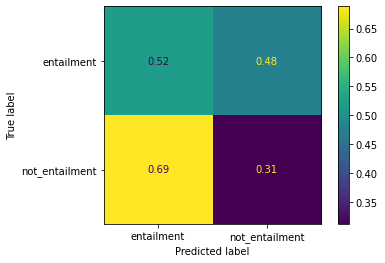

In [81]:
mt = ModelTrainer(tf_vectorizer, log_reg)
mt.fit(dp_train)
mt.valid(dp_valid)